In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

from scipy.interpolate import interp1d
from scipy.integrate import simpson

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from qmostetc import QMostObservatory, SEDTemplate, Spectrum, L1DXU

In [2]:
qsos_params = pd.read_csv('./../QSO_output/QSOs_balanced_training_set/model_input.csv')
qsos_params

,ID,REDSHIFT,absMag,smcDustEBV,LOG_MBH,LOG_REDD,NAME
0,QSO_sim_z7.0_MgIIBlueDeep_3.797m32.0845,7.00,-23.870533,0.004451,8.610297,-0.948264,MgIIBlueDeep_3.797m32.0845
1,QSO_sim_z7.1_MgIIBlueDeep_3.8049m32.078,7.10,-24.147182,0.024990,8.586831,-0.814137,MgIIBlueDeep_3.8049m32.078
2,QSO_sim_z5.35_MgIIBlueDeep_4.045m30.4084,5.35,-25.110907,0.054259,9.210104,-1.051922,MgIIBlueDeep_4.045m30.4084
3,QSO_sim_z5.15_MgIIBlueDeep_4.9565m34.0107,5.15,-22.476839,0.110324,8.286796,-1.182240,MgIIBlueDeep_4.9565m34.0107
4,QSO_sim_z5.9_MgIIBlueDeep_2.1999m35.3336,5.90,-25.991236,0.039964,9.358524,-0.848210,MgIIBlueDeep_2.1999m35.3336
...,...,...,...,...,...,...,...
31680,QSO_sim_z4.9_MgIIBlueDeep_151.2334p2.5492,4.90,-26.398851,0.068704,9.500437,-0.827076,MgIIBlueDeep_151.2334p2.5492
31681,QSO_sim_z4.9_MgIIBlueDeep_176.279p2.1823,4.90,-24.059088,0.065549,8.908089,-1.170634,MgIIBlueDeep_176.279p2.1823
31682,QSO_sim_z4.95_MgIIBlueDeep_22.7516m27.4173,4.95,-23.982973,0.039094,8.974677,-1.267668,MgIIBlueDeep_22.7516m27.4173
31683,QSO_sim_z4.9_MgIIBlueDeep_199.3501p2.3258,4.90,-21.522945,0.041057,8.800819,-2.077821,MgIIBlueDeep_199.3501p2.3258


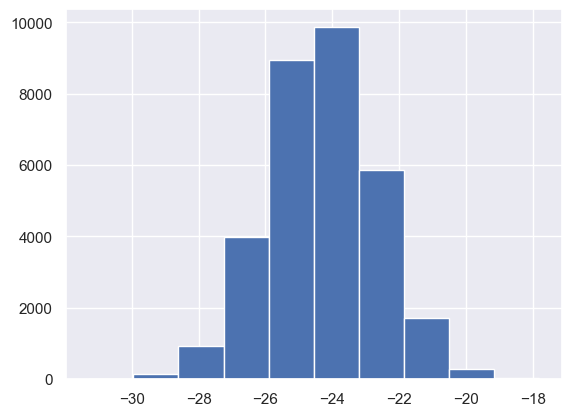

In [3]:
qsos_params.absMag.hist();

In [7]:
qso = qsos_params.sample(1, random_state=4)
qso

,ID,REDSHIFT,absMag,smcDustEBV,LOG_MBH,LOG_REDD,NAME
11818,QSO_sim_z1.7_MgIIGreen_186.3716m21.88,1.7,-26.509617,0.006186,9.119357,-0.40169,MgIIGreen_186.3716m21.88


In [8]:
qso_model = Table.read('./../QSO_output/QSOs_balanced_training_set/' + qso.ID.values[0] + '.fits').to_pandas()
qso_model

,LAMBDA,FLUX_DENSITY
0,3000.0,6.370251e-16
1,3000.1,6.371640e-16
2,3000.2,6.373029e-16
3,3000.3,6.374419e-16
4,3000.4,6.375810e-16
...,...,...
79995,10999.5,5.314574e-17
79996,10999.6,5.314576e-17
79997,10999.7,5.314578e-17
79998,10999.8,5.314580e-17


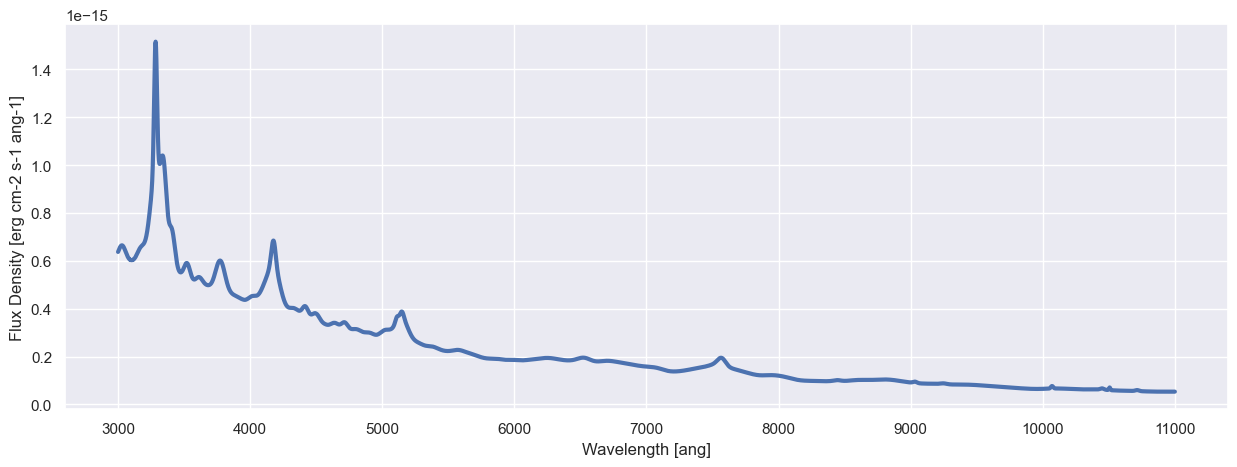

In [38]:
plt.figure(figsize=(15, 5))

plt.plot(qso_model['LAMBDA'], qso_model['FLUX_DENSITY'], lw=3)

plt.xlabel('Wavelength [ang]')
plt.ylabel('Flux Density [erg cm-2 s-1 ang-1]')

plt.show()

In [39]:
decam_z = pd.read_table('./CTIO_DECam.z.dat', sep=' ', names=['LAMBDA', 'transmission'])
# decam_z = pd.read_table('./CTIO_DECam.z_old.dat', sep=' ', names=['LAMBDA', 'transmission'])
decam_z

,LAMBDA,transmission
0,8250,0.00000
1,8255,0.00218
2,8260,0.00434
3,8265,0.00467
4,8270,0.00497
...,...,...
376,10130,0.00171
377,10135,0.00174
378,10140,0.00177
379,10145,0.00089


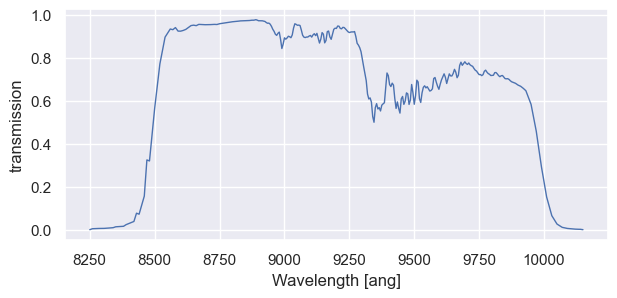

In [40]:
plt.figure(figsize=(7, 3))

plt.plot(decam_z['LAMBDA'], decam_z['transmission'], lw=1)

plt.xlabel('Wavelength [ang]')
plt.ylabel('transmission')

plt.show()

In [41]:
qso_model['LAMBDA']

0         3000.0
1         3000.1
2         3000.2
3         3000.3
4         3000.4
          ...   
79995    10999.5
79996    10999.6
79997    10999.7
79998    10999.8
79999    10999.9
Name: LAMBDA, Length: 80000, dtype: float64

In [42]:
f = interp1d(decam_z['LAMBDA'].values, decam_z['transmission'].values)

decam_z_lambda_interp = np.arange(start=decam_z['LAMBDA'].min(), stop=decam_z['LAMBDA'].max(), step=0.1)
decam_z_trans_interp = f(decam_z_lambda_interp)

In [43]:
diff = np.diff(decam_z_lambda_interp)
np.allclose(diff, 0.1)

True

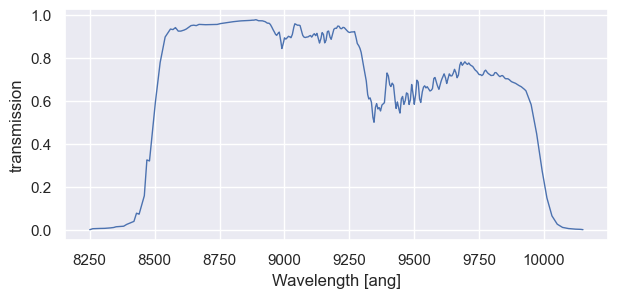

In [44]:
plt.figure(figsize=(7, 3))

plt.plot(decam_z_lambda_interp, decam_z_trans_interp, lw=1)

plt.xlabel('Wavelength [ang]')
plt.ylabel('transmission')

plt.show()

In [45]:
qso_in_filter = qso_model.loc[((qso_model.LAMBDA > np.min(decam_z_lambda_interp)-0.01) & (qso_model.LAMBDA <= np.max(decam_z_lambda_interp)))]
qso_in_filter

,LAMBDA,FLUX_DENSITY
52500,8250.0,9.806253e-17
52501,8250.1,9.806093e-17
52502,8250.2,9.805934e-17
52503,8250.3,9.805774e-17
52504,8250.4,9.805614e-17
...,...,...
71495,10149.5,6.595082e-17
71496,10149.6,6.594889e-17
71497,10149.7,6.594696e-17
71498,10149.8,6.594503e-17


In [46]:
f_lambda = simpson(y=decam_z_trans_interp * qso_in_filter['FLUX_DENSITY'], x=decam_z_lambda_interp)
f_lambda

np.float64(1.0742524110610334e-13)

In [61]:
qso_f_nu = qso_in_filter['FLUX_DENSITY'].values * decam_z_lambda_interp**2
qso_f_nu = qso_f_nu * 3.34e4
qso_f_nu  # janskys

array([0.00022292, 0.00022293, 0.00022293, ..., 0.00022691, 0.0002269 ,
       0.0002269 ], shape=(19000,))

In [62]:
f_nu = simpson(y=decam_z_trans_interp * qso_f_nu, x=decam_z_lambda_interp)
f_nu

np.float64(0.29897570453404687)

In [63]:
zmag = -2.5 * np.log10(f_nu) + 8.90
print(zmag)

10.210910255071052


In [64]:
airmass = 1.1
airmass = np.arccos(1./airmass)*180/np.pi * u.deg
seeing = 0.8

qmost = QMostObservatory('hrs')
obs = qmost(airmass, seeing*u.arcsec, 'gray')

In [65]:
qso_template = SEDTemplate('./../QSO_output/QSOs_balanced_training_set/' + qso.ID.values[0] + '.fits')
obs.set_target(qso_template(zmag*u.ABmag, './../etc/qmostetc/data/sed/filters/CTIO_DECam.z.fits'), 'point')

In [66]:
texp = 1*u.hour

res = obs.expose(texp)
dxu = L1DXU(obs.observatory, res, texp)
etc_output = dxu.joined()

/opt/anaconda3/envs/tf_keras/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


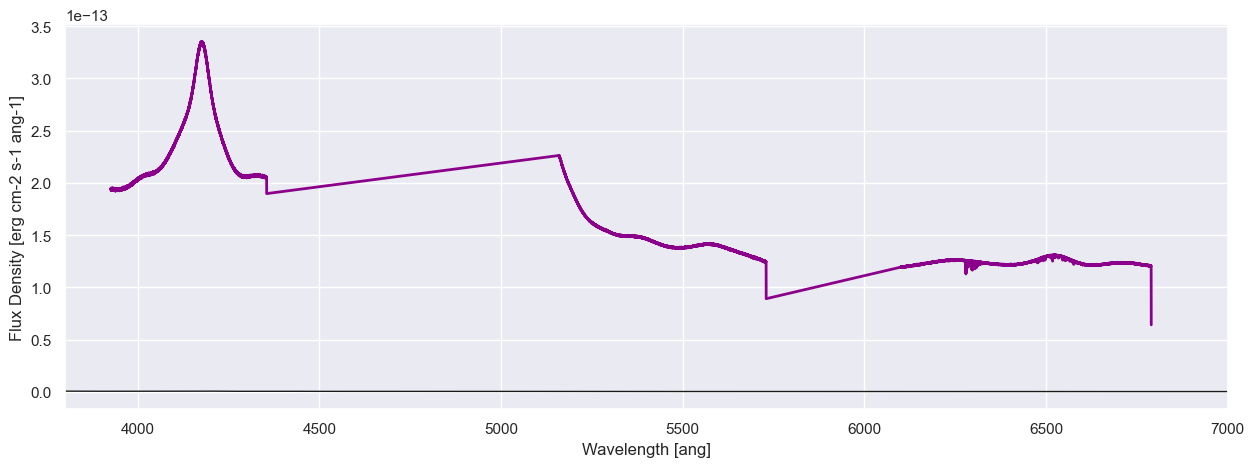

In [67]:
plt.figure(figsize=(15, 5))

plt.plot(qso_model['LAMBDA'], qso_model['FLUX_DENSITY'], lw=1, c='k')
plt.plot(etc_output[1].data['WAVE'][0], etc_output[1].data['FLUX'][0], lw=2, c='darkmagenta')
plt.fill_between(etc_output[1].data['WAVE'][0], 
                 etc_output[1].data['FLUX'][0]-etc_output[1].data['ERR_FLUX'][0], 
                 etc_output[1].data['FLUX'][0]+etc_output[1].data['ERR_FLUX'][0], 
                 alpha=0.5)

plt.xlabel('Wavelength [ang]')
plt.ylabel('Flux Density [erg cm-2 s-1 ang-1]')

plt.xlim(3800, 7000)

plt.show()